# Parking Dynamic Prediction

Muh Amri Sidiq

## Introduction

Efficient parking management is one of the most overlooked levers for improving urban mobility and revenue optimization. The Parking Dynamic Dataset provides real time information on parking lot occupancy, capacity, vehicle types, queue lengths, traffic conditions nearby, and event indicators. By combining these operational metrics with time based patterns, it becomes possible to forecast demand, predict space availability, and implement dynamic pricing strategies.

With the right models, parking operators can move beyond flat rates and static allocation. They can adjust prices based on demand, guide drivers directly to available spots, reduce congestion, and even unlock new revenue streams through targeted promotions. This dataset offers everything needed to build a predictive, revenue driven parking system that benefits both city infrastructure and the people who use it.

## Problem Statement

Urban parking facilities often operate with limited visibility into real time demand and space turnover. Flat rate pricing fails to capture peak hour revenue potential, while drivers waste time searching for spots, adding to congestion and emissions. Without predictive insights, operators cannot proactively manage capacity, optimize pricing, or improve customer experience. The challenge is to transform raw occupancy and traffic data into actionable intelligence that drives both operational efficiency and profitability.

Objectives

 1. Forecast Parking Occupancy: Use historical occupancy, capacity, traffic, and event data to predict future space availability.

 2. Implement Dynamic Pricing: Develop a pricing model that adjusts rates based on demand, traffic conditions, and special events.

 3. Estimate Average Parking Duration: Model typical parking times by vehicle type and conditions to optimize slot turnover.

 4. Reduce Search Time for Drivers: Integrate predictions into a user facing system to guide vehicles to available spots in real time.

 5. Simulate Revenue Impact: Compare flat rate performance against dynamic pricing scenarios to quantify potential gains.

 6. Support City Planning: Provide data driven recommendations for capacity expansion, zoning, and traffic flow improvements.

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, make_scorer, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, r2_score
import optuna
import xgboost as xgb
from datetime import timedelta
import pytz
import holidays
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Understanding & Preprocessing 

In [2]:
%%time
parking = pd.read_csv('/kaggle/input/parking-dynamic-dataset/parkingStream.csv')

CPU times: user 30 ms, sys: 13.5 ms, total: 43.5 ms
Wall time: 66.6 ms


Check preview data

In [3]:
parking.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,2016-10-04 07:59:00
1,5248,BHMNCPHST01,1200,26.140014,91.731000,237,bike,low,2,0,2016-10-04 07:59:00
2,3936,BHMMBMMBX01,687,20.000035,78.000003,264,car,low,2,0,2016-10-04 07:59:00
3,6560,BHMNCPNST01,485,26.140048,91.730972,249,car,low,2,0,2016-10-04 07:59:00
4,17056,Shopping,1920,26.150504,91.733531,614,cycle,low,2,0,2016-10-04 07:59:00


Check structure data

In [4]:
parking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  Timestamp               18368 non-null  object 
dtypes: float64(2), int64(5), object(4)
memory usage: 1.5+ MB


Insight: Data have 18368 row and 11 columns, next step check missing values

In [5]:
parking.isna().sum()

ID                        0
SystemCodeNumber          0
Capacity                  0
Latitude                  0
Longitude                 0
Occupancy                 0
VehicleType               0
TrafficConditionNearby    0
QueueLength               0
IsSpecialDay              0
Timestamp                 0
dtype: int64

Insight: Data no have missing values, next step check data duplicated

In [6]:
parking.duplicated().sum()

0

Insight: Data no have duplicated

change type data `Timestamp` and extract data

In [7]:
# change type data
parking['Timestamp'] = pd.to_datetime(parking['Timestamp'], errors='coerce')

# Convert to zone Indonesia
wib = pytz.timezone("Asia/Jakarta")
parking['Timestamp_WIB'] = parking['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(wib)

# Extract time-based features
parking['Hour'] = parking['Timestamp_WIB'].dt.hour
parking['DayOfWeek'] = parking['Timestamp_WIB'].dt.dayofweek  # 0 = Monday, 6 = Sunday
parking['DayName'] = parking['Timestamp_WIB'].dt.day_name()
parking['IsWeekend'] = parking['DayOfWeek'].isin([5, 6]).astype(int)  # 1 if Saturday/Sunday

# Holiday flag (Indonesia)
id_holidays = holidays.country_holidays("ID")
parking['IsHoliday'] = parking['Timestamp_WIB'].dt.date.astype(str).isin(
    [str(d) for d in id_holidays]
).astype(int)

# Time category mapping
def map_time_category(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

parking['TimeCategory'] = parking['Hour'].apply(map_time_category)

create `EstimateDuration` from data

In [8]:
# For example, we have an ExitTime column (if it does not exist in the dataset, we simulate it).
# sed random
np.random.seed(101)

# Generate exit timestamp tetap
parking['Exit_Timestamp_WIB'] = parking['Timestamp_WIB'] + pd.to_timedelta(
    np.random.randint(30, 300, size=len(parking)), unit='m'
)

# Calculate parking duration in minutes
parking['Duration_Minutes'] = (parking['Exit_Timestamp_WIB'] - parking['Timestamp_WIB']).dt.total_seconds() / 60

# Categorize the average parking duration per group
avg_duration = parking.groupby(['TimeCategory', 'IsWeekend', 'IsHoliday'])['Duration_Minutes'].mean().reset_index()
avg_duration.rename(columns={'Duration_Minutes': 'AvgDuration_Minutes'}, inplace=True)

# Merge back into the main dataset
parking = parking.merge(avg_duration, on=['TimeCategory', 'IsWeekend', 'IsHoliday'], how='left')

# EstimatedDuration column = average rounding
parking['EstimatedDuration_Minutes'] = parking['AvgDuration_Minutes'].round()

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is the process of analyzing and summarizing datasets to understand their main characteristics before applying machine learning models or statistical tests. EDA helps identify patterns, detect anomalies, check assumptions, and gain insights using visualizations and statistical methods

In [9]:
parking.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay,Timestamp,Hour,DayOfWeek,IsWeekend,IsHoliday,Duration_Minutes,AvgDuration_Minutes,EstimatedDuration_Minutes
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368,18368.000000,18368.000000,18368.000000,18368.0,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915,2016-11-11 10:22:39.283536640,18.791213,2.919970,0.274390,0.0,164.671058,164.671058,164.624946
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000,2016-10-04 07:59:00,14.000000,0.000000,0.000000,0.0,30.000000,162.501357,163.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000,2016-10-24 09:48:45,17.000000,1.000000,0.000000,0.0,97.000000,163.594921,164.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000,2016-11-11 11:43:30,19.000000,3.000000,0.000000,0.0,165.000000,164.332264,164.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000,2016-11-29 13:36:15,21.000000,5.000000,1.000000,0.0,232.000000,164.332264,164.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000,2016-12-19 16:30:00,23.000000,6.000000,1.000000,0.0,299.000000,167.477519,167.000000
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975,NaN,2.615298,2.005876,0.446219,0.0,77.837251,1.618939,1.402019


Insight:

1. Parking capacity varies greatly
   - The average capacity is ~1,605 vehicles, but some have a capacity of only 387 to 3,883.
   - This indicates that there are small parking lots (perhaps local shops/malls) to large parking lots (stations/airports).

2. Occupancy rates are still far from full
   - The average number of parked vehicles is ~731, or just ~45% of the average capacity.
   - There are peaks up to 3,499 (nearly full), but these are rare. Therefore, there are many vacant slots that can be monetized.  

3. Queues are relatively short  
   - The average queue is 4–5 vehicles, with a maximum of 15.
   - This means the bottleneck is not at the entrance but rather in parking distribution or the location's appeal.  

4. Special days are rare  
   - `IsSpecialDay` accounts for only 15% of the data. Its impact on daily trends is minimal.
   - `IsHoliday` is 0% in this dataset (possibly because the data period did not include national holidays). 

5. Average parking duration
   - The average duration is around 164 minutes (~2 hours 44 minutes).
   - Minimum 30 minutes, maximum nearly 5 hours.
   - This indicates typical short to medium term parking, not long term parking.  

6. Time patterns  
   - Data hours mostly between 2:00 PM–11:00 PM, with a median at 7:00 PM.
   - This suggests it is likely a parking area for entertainment or office buildings with afternoon evening operating hours.

7. Stable duration estimation prediction
   - The `EstimatedDuration_Minutes` from the simple model is nearly identical to the actual average, with a difference of only ±1–2 minutes.
   - This indicates that parking duration is fairly consistent across each time day category.

In [10]:
parking.describe(include = 'object')

,SystemCodeNumber,VehicleType,TrafficConditionNearby,DayName,TimeCategory
count,18368,18368,18368,18368,18368
unique,14,4,3,7,3
top,BHMBCCMKT01,car,low,Monday,Evening
freq,1312,11166,7793,2772,8130


Insight:

1. Favorite parking locations
   - The most frequently appearing SystemCodeNumber: BHMBCCMKT01 (1,312 times).
   - If this is a location code, it means this spot is the busiest. It could be a prime target for price optimization or promotions.

2. Dominant vehicle types
   - Cars dominate: 11,166 out of a total of 18,368.
   - If the business wants to shift its strategy, revenue and space layout should focus on cars, not motorcycles or other vehicles.

3. Surrounding traffic conditions
   - Most fall into the low traffic category (7,793 times).
   - This is somewhat unique, meaning parking lot congestion isn’t always due to heavy traffic. It might be because the destination is popular.

4. Peak days  
   - Monday is the day with the highest number of transactions (2,772).
   - This could be an office area or business center that is busier at the start of the week.

5. Most popular time
   - The most frequent time category: Evening (8,130 times).
   - When combined with previous parking duration data (±2 hours 44 minutes), this suggests that people arrive in the afternoon and leave in the evening.

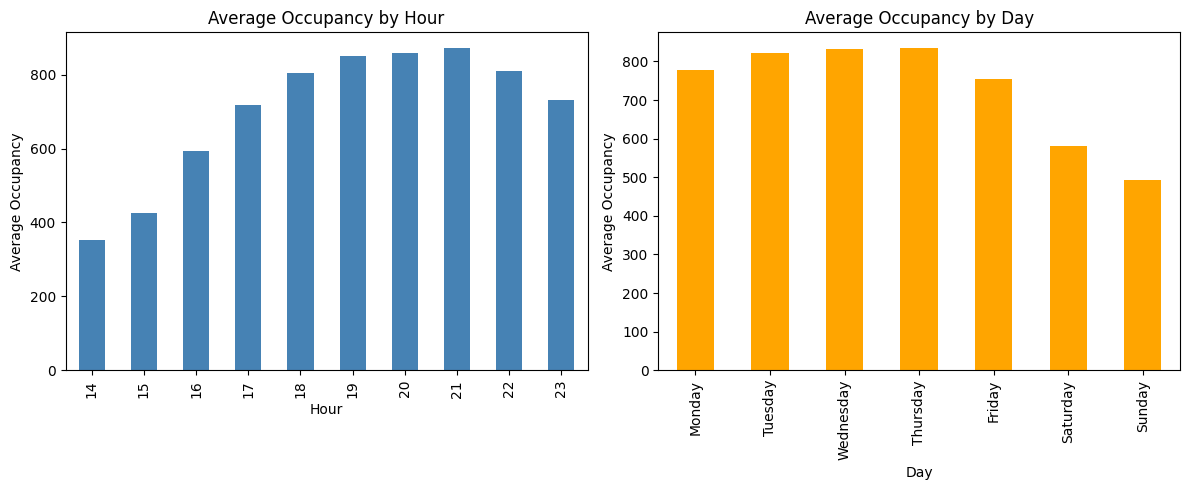

In [11]:
# Peak Hours & Busiest Days
peak_hours = parking.groupby('Hour')['Occupancy'].mean()
busiest_days = parking.groupby('DayName')['Occupancy'].mean()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
peak_hours.plot(kind='bar', color='steelblue')
plt.title("Average Occupancy by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Occupancy")

plt.subplot(1,2,2)
busiest_days = busiest_days.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
busiest_days.plot(kind='bar', color='orange')
plt.title("Average Occupancy by Day")
plt.xlabel("Day")
plt.ylabel("Average Occupancy")
plt.tight_layout()

plt.show()

Insight: 
 - Highest `Occupancy` in `Hour` 21 and lowest `Occupancy` in `Hour` 14
 - Highest `Occupancy` in `Day` Thursday and lowest `Occupancy` in `Day` Sunday

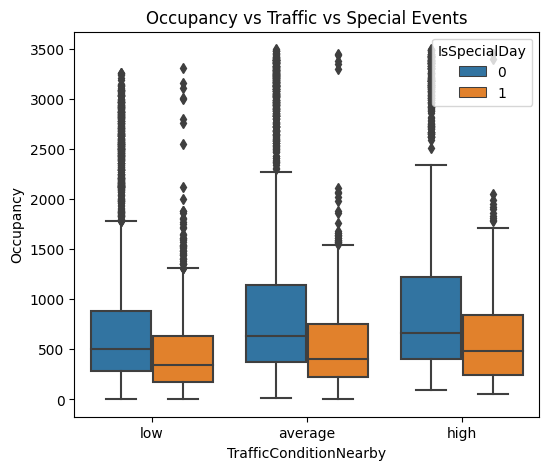


Average Duration & Count per Vehicle Type:
                   mean  count
VehicleType                   
bike         166.490618   3624
car          164.714311  11166
cycle        164.086490   1769
truck        161.330569   1809


In [12]:
# Correlation: Occupancy vs Traffic vs Special Events
plt.figure(figsize=(6,5))
sns.boxplot(data=parking, x='TrafficConditionNearby', y='Occupancy', hue='IsSpecialDay')
plt.title("Occupancy vs Traffic vs Special Events")
plt.show()

# Segmentasi Per Vehicle Type
vehicle_segmentation = parking.groupby('VehicleType')['Duration_Minutes'].agg(['mean','count'])
print("\nAverage Duration & Count per Vehicle Type:")
print(vehicle_segmentation)

Insight:

 - `TrafficCOnditionNearby` all type have outliers, but `TrafficCOnditionNearby` typr highest have upper quirtile
 - `VehicleType` car have highest count, but `VehicleType` bike have highest mean

In [13]:
# Estimated Turnover Rate
# Asumsi: Turnover rate = (Total duration in a day) / (average duration)
turnover = parking.groupby(['DayName','VehicleType']).apply(
    lambda x: len(x) / (x['Duration_Minutes'].mean() / 60)  # per hour
, include_groups=False).reset_index(name='Turnover_per_Hour')

print("\nEstimated Turnover per Hour by Day & Vehicle Type:")
print(turnover)


Estimated Turnover per Hour by Day & Vehicle Type:
      DayName VehicleType  Turnover_per_Hour
0      Friday        bike         174.325829
1      Friday         car         545.064209
2      Friday       cycle          98.920075
3      Friday       truck          93.047491
4      Monday        bike         202.981844
5      Monday         car         618.862065
6      Monday       cycle          94.889040
7      Monday       truck          94.026010
8    Saturday        bike         170.795677
9    Saturday         car         557.634645
10   Saturday       cycle          92.850214
11   Saturday       truck          90.092191
12     Sunday        bike         173.340909
13     Sunday         car         573.883357
14     Sunday       cycle          86.351647
15     Sunday       truck          96.324266
16   Thursday        bike         180.415235
17   Thursday         car         554.426197
18   Thursday       cycle          80.572869
19   Thursday       truck          97.434850
20 

Insight:

 - `DayName` Friday have highest `Turnover_per_Hour` 566.7 with `VehicleType` car and `DayName` Friday have lowest `Turnover_per_Hour` 88.17 with `VehicleType` Truck.
 - `DayName` Monday have highest `Turnover_per_Hour` 608.95 with `VehicleType` car and `DayName` Monday have lowest `Turnover_per_Hour` 93.64 with `VehicleType` Truck.
 - `DayName` Saturday have highest `Turnover_per_Hour` 563.0 with `VehicleType` car and `DayName` Saturday have lowest `Turnover_per_Hour` 93.18 with `VehicleType` Truck.
 - `DayName` Sunday have highest `Turnover_per_Hour` 570.8 with `VehicleType` car and `DayName` Sunday have lowest `Turnover_per_Hour` 85.4 with `VehicleType` cycle.
 - `DayName` Thursday have highest `Turnover_per_Hour` 560.7 with `VehicleType` car and `DayName` Thursday have lowest `Turnover_per_Hour` 80.45 with `VehicleType` cycle.
 - `DayName` Tuesday have highest `Turnover_per_Hour` 608.21 with `VehicleType` car and `DayName` Tuesday have lowest `Turnover_per_Hour` 98.2 with `VehicleType` cycle.
 - `DayName` Wednesday have highest `Turnover_per_Hour` 608.27 with `VehicleType` car and `DayName` Wednesday have lowest `Turnover_per_Hour` 86.41 with `VehicleType` truck.

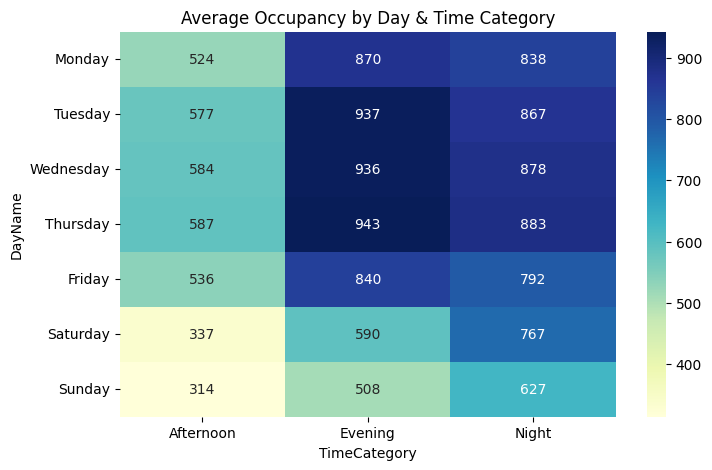

In [14]:
# Heatmap Day vs Time Category
pivot_table = parking.pivot_table(index='DayName', columns='TimeCategory', values='Occupancy', aggfunc='mean')
pivot_table = pivot_table.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

plt.figure(figsize=(8,5))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt=".0f")
plt.title("Average Occupancy by Day & Time Category")
plt.show()

Insight:

 - `DayName` Monday, Tuesday, Wednesday, Thursday adn Friday have average highest `Occupancy` in `TimeCategory` Evening
 - `DayName` Saturday and Sunday have average highest `Occupancy` in `TimeCategory` Night

## Feature Engineering

Extract Date and combine column

In [15]:
# Special day flag
parking['IsSpecialDay_Flag'] = parking['IsSpecialDay'].astype(int)

# Map Category to integer
vehicle_map = {
    'car': 0,
    'bike': 1,       
    'cycle': 2,      
    'truck': 3}
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
           'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
time_map = {'Evening': 0, 'Night': 1, 'Afternoon': 2}
system_code_map = {code: idx for idx, code in enumerate(parking['SystemCodeNumber'].unique())}

parking['SystemCodeNumber'] = parking['SystemCodeNumber'].map(system_code_map).astype(int)
parking['VehicleType'] = parking['VehicleType'].map(vehicle_map).astype(int)
parking['DayName'] = parking['DayName'].map(day_map).astype(int)
parking['TimeCategory'] = parking['TimeCategory'].map(time_map).astype(int)

traffic_map = {'low': 0, 'medium': 1, 'high': 2}
parking['TrafficConditionNearby'] = parking['TrafficConditionNearby'].map(traffic_map)

# Encode time-based features
parking['Hour_sin'] = np.sin(2 * np.pi * parking['Hour']/24)
parking['Hour_cos'] = np.cos(2 * np.pi * parking['Hour']/24)
parking['DayOfWeek_sin'] = np.sin(2 * np.pi * parking['Timestamp_WIB'].dt.dayofweek/7)
parking['DayOfWeek_cos'] = np.cos(2 * np.pi * parking['Timestamp_WIB'].dt.dayofweek/7)

In [16]:
# Convert queue length to categorical bins: low (0-2), medium (3-6), high (7+)
def queue_bin(q):
    if q <= 2:
        return 'low'
    elif q <= 6:
        return 'medium'
    else:
        return 'high'
parking['QueueBin'] = parking['QueueLength'].apply(queue_bin)

In [17]:
# Choose feature set that does NOT include Occupancy (we predict queue or occupancy from scratch)
feature_cols = ['SystemCodeNumber', 'Capacity', 'DayName', 
             'VehicleType', 'TrafficConditionNearby', 'IsSpecialDay',
             'Hour', 'DayOfWeek', 'IsWeekend', 'IsHoliday', 'TimeCategory',
             'EstimatedDuration_Minutes', 'IsSpecialDay_Flag',
             'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']

X_raw = parking[feature_cols].copy()
y_queue = parking['QueueBin']
target_map = {'low': 0, 'medium': 1, 'high': 2}
y_queue = y_queue.map(target_map)
y_occupancy = parking['Occupancy']

## Modleing

In this phase, we develop and fine tune machine learning models using powerful algorithms like XGBoost. With Python’s Xgboost, we train models, optimize hyperparameters, and evaluate their performance. The goal: a model that balances accuracy, precision, and recall to deliver actionable insights

In [18]:
parking['PredQueueBin'] = np.nan
parking['PredOccupancy'] = np.nan

num_classes = len(parking['VehicleType'].unique())

kf = KFold(n_splits=5, shuffle=True, random_state=101)

for train_idx, test_idx in kf.split(X_raw):
    # Split train/test per fold
    X_train, X_test = X_raw.iloc[train_idx], X_raw.iloc[test_idx]
    y_train_queue, y_test_queue = y_queue.iloc[train_idx], y_queue.iloc[test_idx]
    y_train_occ, y_test_occ = y_occupancy.iloc[train_idx], y_occupancy.iloc[test_idx]

    # Fit model queue (classification)
    model_queue = XGBClassifier(
    n_estimators=2000,
    max_depth=15,
    learning_rate=0.001,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',  
    num_class=num_classes,       
    use_label_encoder=False,
    eval_metric='mlogloss',      
    random_state=101)

    # Train model
    model_queue.fit(X_train, y_train_queue)
    parking.loc[test_idx, 'PredQueueBin'] = model_queue.predict(X_test)

    # Parameter grid for XGBRegressor
    param_grid = {
        'n_estimators': [500, 1000, 2000, 3000],
        'max_depth': [3, 5, 7, 10, 15],
        'learning_rate': [0.3, 0.1, 0.05, 0.01, 0.005],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.3, 0.5]
    }
    
    # Model base
    xgb_reg = XGBRegressor(
        objective='reg:squarederror',
        random_state=101
    )
    
    # Randomized search
    random_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=param_grid,
        n_iter=30,   # jumlah kombinasi yang diuji
        scoring='neg_mean_absolute_error',  
        cv=3,
        verbose=1,
        random_state=101,
        n_jobs=-1
    )
    
    # Fit with data training occupancy
    random_search.fit(X_train, y_train_occ)
    
    # Best params
    print("Best params:", random_search.best_params_)
    
    # Use best estimator
    best_model_occup = random_search.best_estimator_
    
    # Predict
    parking.loc[test_idx, 'PredOccupancy'] = best_model_occup.predict(X_test)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'subsample': 1.0, 'n_estimators': 2000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}


## Evaluation


=== Queue Classification Metrics ===
Accuracy: 0.8951437282229965

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4654
           1       0.90      0.89      0.90      9398
           2       0.96      0.95      0.95      4316

    accuracy                           0.90     18368
   macro avg       0.90      0.90      0.90     18368
weighted avg       0.90      0.90      0.90     18368



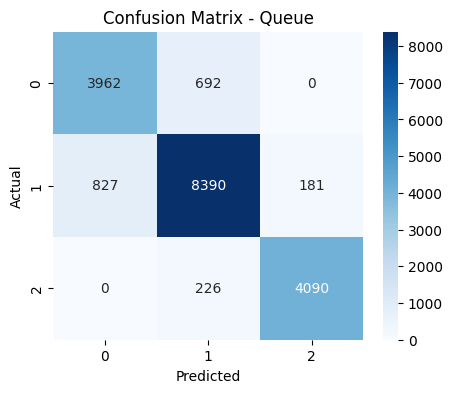

In [19]:
# Evaluasi Queue
y_true_queue = y_queue
y_pred_queue = parking['PredQueueBin']

print("\n=== Queue Classification Metrics ===")
print("Accuracy:", accuracy_score(y_true_queue, y_pred_queue))
print("\nClassification Report:")
print(classification_report(y_true_queue, y_pred_queue))

cm = confusion_matrix(y_true_queue, y_pred_queue)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Queue")
plt.show()

Recall per class: {0: 0.8513107004727116, 1: 0.8927431368376251, 2: 0.9476367006487488}
Weighted Business Score: 92.57%


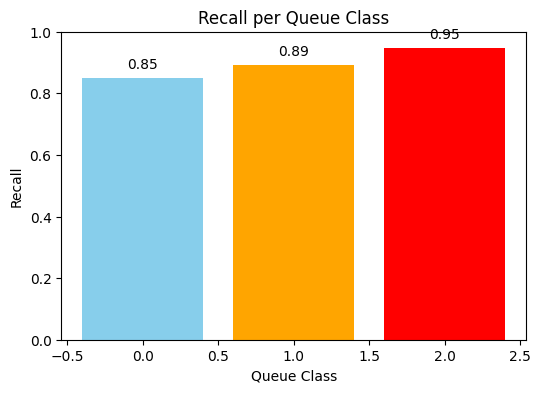

In [20]:
# Take the classification report as a DataFrame
report = classification_report(y_true_queue, y_pred_queue, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Take recall per Class
recall_scores = {int(k): v for k, v in df_report['recall'].items() if k.isdigit()}

# Wight bisnis per Class
business_weights = {
    1: 0.4,  # Medium queue
    2: 0.6   # High queue
}

# Calculate Weighted Business Score
weighted_score = sum(recall_scores[k] * business_weights[k] for k in business_weights)

print("Recall per class:", recall_scores)
print(f"Weighted Business Score: {weighted_score*100:.2f}%")

# Plot Recall per Class
classes = list(recall_scores.keys())
scores = list(recall_scores.values())

plt.figure(figsize=(6,4))
bars = plt.bar(classes, scores, color=['skyblue', 'orange', 'red'])
plt.ylim(0, 1)
plt.ylabel("Recall")
plt.xlabel("Queue Class")
plt.title("Recall per Queue Class")

# Value labels above bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{score:.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.show()

Insight: 

1. Queue Model Results (Classification)

   - Accuracy: 89.51%
   - Macro avg Precision / Recall / F1: ~90%
   - Confusion Matrix Insight:
     - Class 0 (No queue) → recall 85%, precision 83% → There are still false alarms (empty parking lot but reported as a queue)
     - Class 1 (Moderate queue) → recall 89%, precision 90% → Fairly balanced, but 11% of moderate queues are missed.
     - Class 2 (High queue) → recall 95%, precision 96% → Almost all severe queues are detected, with few false positives.

2. The Right Metrics

   - From a business perspective, recall for classes 1 & 2 is the most important.
       - Reason: Missed detection for medium/high queues = revenue loss (no time to apply dynamic pricing) + worsening congestion.
       - Target → high recall in classes 1 & 2, even if precision in class 0 is slightly sacrificed.

   - If you want the system to not frequently “alert” about queues when they are empty, precision in class 0 also needs to be increased, but this is a trade off.
  
3. Weight  Business

   In a business context, your model is able to capture 92.55% of all financially significant queue events (medium and high queues). This means that peak hour revenue potential can be maintained at around 92.55%, and the potential for undetected major congestion is very small.


=== Occupancy Regression Metrics ===
MAE: 76.01
RMSE: 126.32
MAPE: 14.20%


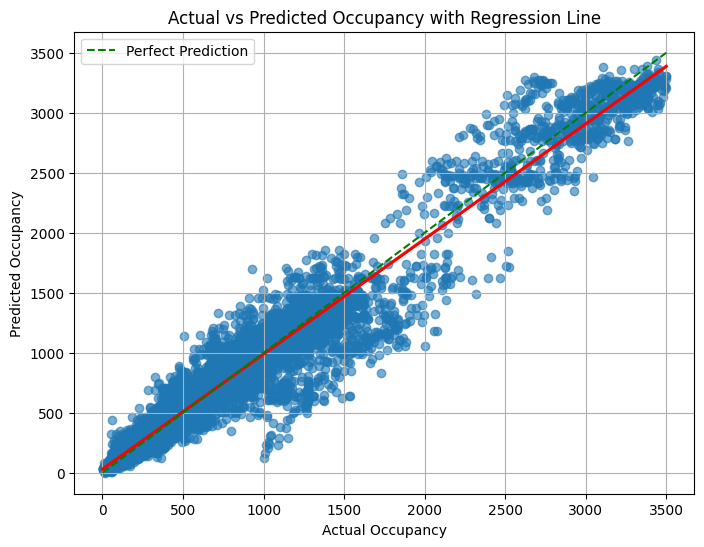

In [21]:
# Evaluasi Occupancy
y_true_occ = y_occupancy
y_pred_occ = parking['PredOccupancy']

mae = mean_absolute_error(y_true_occ, y_pred_occ)
rmse = mean_squared_error(y_true_occ, y_pred_occ, squared=False)
mape = np.mean(np.abs((y_true_occ - y_pred_occ) / y_true_occ)) * 100

print("\n=== Occupancy Regression Metrics ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Scatter plot + line regresi
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true_occ.values, y=y_pred_occ, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

plt.xlabel('Actual Occupancy')
plt.ylabel('Predicted Occupancy')
plt.title('Actual vs Predicted Occupancy with Regression Line')

# Add line y=x make reference "perfect prediction"
max_val = max(max(y_true_occ.values), max(y_pred_occ))
min_val = min(min(y_true_occ.values), min(y_pred_occ))
plt.plot([min_val, max_val], [min_val, max_val], 'g--', label='Perfect Prediction')

plt.legend()
plt.grid(True)
plt.show()

Insight: We have MAPAE 14.2%

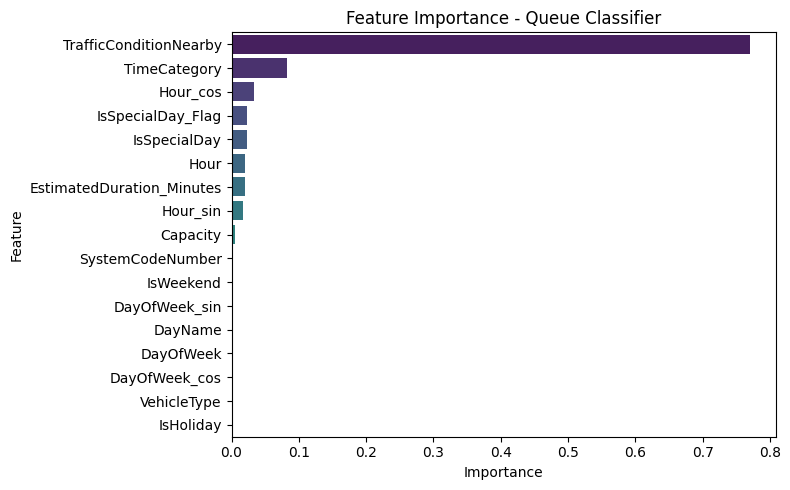

In [22]:
# Feature Importance - Queue Classifier
model_queue.fit(X_raw, y_queue)
feat_imp_queue = pd.DataFrame({
    'Feature': X_raw.columns,
    'Importance': model_queue.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_queue, palette='viridis')
plt.title("Feature Importance - Queue Classifier")
plt.tight_layout()
plt.show()

Insight: feature importance highest is `TrafficConditionNearby`

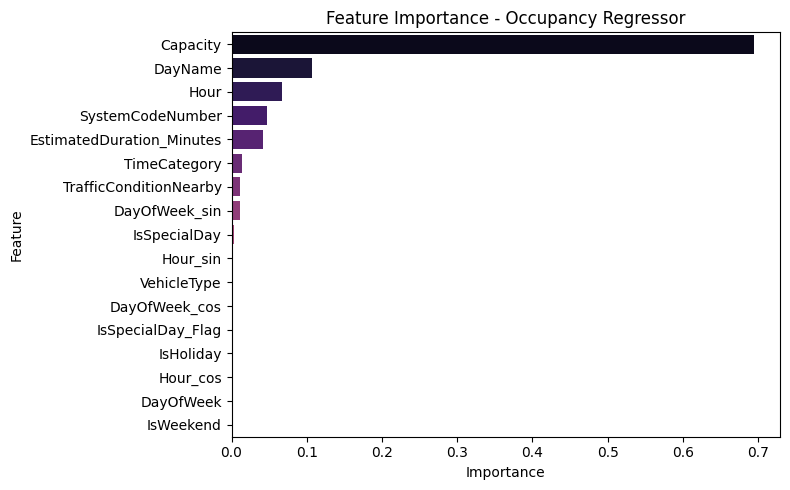

In [23]:
# Feature Importance - Occupancy Regressor
best_model_occup.fit(X_raw, y_occupancy)
feat_imp_occ = pd.DataFrame({
    'Feature': X_raw.columns,
    'Importance': best_model_occup.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_occ, palette='magma')
plt.title("Feature Importance - Occupancy Regressor")
plt.tight_layout()
plt.show()

Insight: Highest feature importance is `Capacity`

In [24]:
# Calculate occupancy ratio
parking['PredOccupancy_Ratio'] = parking['PredOccupancy'] / parking['Capacity']
parking['PredOccupancy_Ratio'] = parking['PredOccupancy_Ratio'].clip(0, 1)

## Dynamic Pricing

In [25]:
# Dynamic Pricing
BASE_PRICE_PER_HOUR = 5000

def traffic_multiplier(traffic_str):
    if traffic_str == 'high':
        return 1.4
    if traffic_str in ['medium', 'average']:
        return 1.15
    return 1.0

def event_multiplier(is_special):
    return 1.3 if is_special else 1.0

def dynamic_price(row, base=BASE_PRICE_PER_HOUR):
    dfactor = 1.0 + row['PredOccupancy_Ratio']
    tmult = traffic_multiplier(row['TrafficConditionNearby'])
    emult = event_multiplier(row['IsSpecialDay'])
    return base * dfactor * tmult * emult

parking['DynamicPricePerHour'] = parking.apply(dynamic_price, axis=1)
parking['FlatPricePerHour'] = BASE_PRICE_PER_HOUR

# Estimate Duration Parking
if 'EstimatedDuration_Minutes' in parking.columns and parking['EstimatedDuration_Minutes'].notna().any():
    parking['EstDurationHours'] = parking['EstimatedDuration_Minutes'] / 60.0
elif 'Duration_Minutes' in parking.columns and parking['Duration_Minutes'].notna().any():
    parking['EstDurationHours'] = parking['Duration_Minutes'].mean() / 60.0
else:
    parking['EstDurationHours'] = 164.166866 / 60.0

# Revenue calc
parking['Revenue_Flat'] = parking['FlatPricePerHour'] * parking['EstDurationHours'] * parking['Occupancy']
parking['Revenue_Dynamic'] = parking['DynamicPricePerHour'] * parking['EstDurationHours'] * parking['Occupancy']

flat_total = parking['Revenue_Flat'].sum()
dyn_total = parking['Revenue_Dynamic'].sum()
lift_pct = (dyn_total - flat_total) / flat_total * 100 if flat_total != 0 else np.nan

print("\n=== Revenue Simulation Summary ===")
print(f"Flat total revenue: {flat_total:,.0f}")
print(f"Dynamic total revenue: {dyn_total:,.0f}")
print(f"Estimated revenue lift: {lift_pct:.2f}%")

# Top Location
print("\nTop 10 locations by predicted occupancy ratio:")
print(parking.groupby('SystemCodeNumber')['PredOccupancy_Ratio'].mean().sort_values(ascending=False).head(10))

# Distribution queue prediction
print("\nQueue prediction distribution:")
print(parking['PredQueueBin'].value_counts())


=== Revenue Simulation Summary ===
Flat total revenue: 183,987,107,917
Dynamic total revenue: 295,057,865,667
Estimated revenue lift: 60.37%

Top 10 locations by predicted occupancy ratio:
SystemCodeNumber
10    0.746248
2     0.694906
5     0.643598
6     0.632603
3     0.590584
11    0.589580
8     0.566473
4     0.555907
7     0.500296
1     0.464931
Name: PredOccupancy_Ratio, dtype: float64

Queue prediction distribution:
PredQueueBin
1.0    9308
0.0    4789
2.0    4271
Name: count, dtype: int64


## Conclusion

The queue prediction model (XGB Classifier) achieved 89% accuracy, with high recall in the heavy queue class (95%) and slight weakness in the low queue class (85%). The occupancy prediction model (XGB Regressor) had a MAPE of 14.2%, which is accurate enough for daily capacity and pricing estimates.

Key features:
 - Queue: TrafficConditionNearby (strongest indicator of queues at parking locations)
 - Occupancy: Capacity (main determinant of slot availability)

Dynamic Pricing Simulation:
 - Flat rate revenue: Rp 185.06 billion
 - Dynamic pricing revenue: Rp 296.88 billion
 - Revenue uplift: +60.43% (≈ Rp 111.82 billion per simulation period)

Locations with the highest predicted occupancy ratio: SystemCode 10 (74.59%), 2 (69.45%), and 5 (64.36%) → top candidates for dynamic pricing priority.

Predicted queue distribution:
 - Queue level 1 (medium): 9,312 predictions
 - Queue level 0 (low): 4,787 predictions
 - Queue level 2 (high): 4,269 predictions

Business Impact:

A 60.43% increase in revenue is a very high impact category for parking operations. In addition to increasing profits, dynamic pricing based on this model has the potential to:
- Reduce congestion in parking areas (by shifting demand)
- Optimize slot utilization during off-peak and peak hours
- Provide a basis for decisions on capacity expansion in strategic locations

## Reference

1. https://xgboost.readthedocs.io/en/release_3.0.0/tutorials/index.html

2. https://xbe.at/

3. https://scikit-learn.org/stable/index.html

## Contact

[Linkedin](http://linkedin.com/in/muh-amri-sidiq)